# Train Exercise Classifier (RandomForest)
Made by GOAT!!!

This notebook trains a RandomForest on features generated from MediaPipe Pose landmarks.

Prerequisites:
first ye dono chalana hai and make a venv file using python 3.8 
- You already ran landmark extraction and feature building:
  - `python scripts/extract_landmarks_from_videos.py --dir data/raw --out data/landmarks --fps_reduce 2`
  - `python scripts/build_features.py --landmarks_dir data/landmarks --out data/features/features.csv --win 30 --stride 15`
- Using the .venv38 (Python 3.8.10) environment.

In [2]:
import os, sys
print("cwd:", os.getcwd())
print("python:", sys.executable)

cwd: d:\python fitness ai trial
python: d:\python fitness ai trial\.venv38\Scripts\python.exe


In [3]:
# Versions and imports
import sys, json, os
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Python:", sys.version.split()[0])
import sklearn
print("sklearn:", sklearn.__version__)
try:
    import mediapipe as mp
    import cv2
    print("mediapipe:", getattr(mp, "__version__", "unknown"))
    print("opencv:", cv2.__version__)
except Exception as e:
    print("(Note) Could not import mediapipe/cv2 here:", e)
print("pandas:", pd.__version__)

# Plotting defaults
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (4, 4)

Python: 3.8.10
sklearn: 1.3.2
mediapipe: 0.10.10
opencv: 4.12.0
pandas: 1.5.3


In [4]:
# Configuration
FEATURES_CSV = Path("data/features/features.csv")
MODEL_OUT = Path("models/model.joblib")
META_OUT = Path("models/model_meta.json")

N_TREES = 200
RANDOM_STATE = 42

assert FEATURES_CSV.exists(), f"Missing {FEATURES_CSV}. Run feature building first."
MODEL_OUT.parent.mkdir(parents=True, exist_ok=True)

In [5]:
# Load features
df = pd.read_csv(FEATURES_CSV)
meta_cols = {"video", "label", "start", "end"}
feature_cols = [c for c in df.columns if c not in meta_cols]

print("Rows:", len(df), "| Features:", len(feature_cols))
print("Unique videos:", df["video"].nunique())
print("Label counts:", Counter(df["label"]))

display(df.head(3)[list(feature_cols)[:6] + ["label", "video"]])

Rows: 49 | Features: 56
Unique videos: 6
Label counts: Counter({'bicep_curl': 20, 'shoulder_press': 17, 'squats': 12})


,angle_elbow_L_mean,angle_elbow_L_std,angle_elbow_L_min,angle_elbow_L_max,angle_elbow_L_p10,angle_elbow_L_p90,label,video
0,73.727913,50.270992,5.228434,133.326660,12.695087,129.737239,bicep_curl,bicep_curl_01.mp4
1,90.095337,45.308342,12.504906,133.326660,14.939388,131.186629,bicep_curl,bicep_curl_01.mp4
2,72.719521,45.897911,12.504906,132.334137,13.528738,129.417090,bicep_curl,bicep_curl_01.mp4


GroupKFold (n_splits=5) accuracy: mean=0.680 ± 0.412

Classification report (grouped CV):

                precision    recall  f1-score   support

    bicep_curl       0.95      1.00      0.98        20
shoulder_press       0.48      0.65      0.55        17
        squats       0.00      0.00      0.00        12

      accuracy                           0.63        49
     macro avg       0.48      0.55      0.51        49
  weighted avg       0.55      0.63      0.59        49



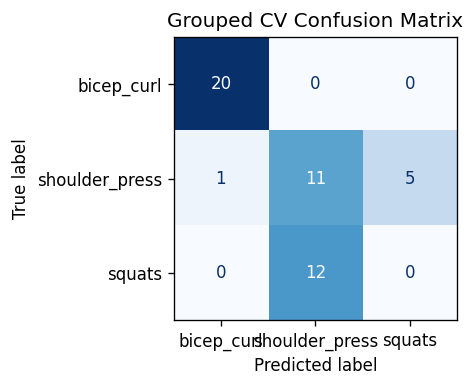

In [6]:
# Grouped cross-validation by video (sanity evaluation)
X = df[feature_cols].values
y = df["label"].values
groups = df["video"].values

unique_groups = np.unique(groups)
n_splits = min(5, len(unique_groups)) if len(unique_groups) >= 2 else 0

if n_splits >= 2:
    gkf = GroupKFold(n_splits=n_splits)
    base_rf = RandomForestClassifier(
        n_estimators=N_TREES, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1
    )
    scores = cross_val_score(base_rf, X, y, cv=gkf, groups=groups, scoring="accuracy", n_jobs=-1)
    print(f"GroupKFold (n_splits={n_splits}) accuracy: mean={scores.mean():.3f} ± {scores.std():.3f}")

    y_pred = cross_val_predict(base_rf, X, y, cv=gkf, groups=groups, n_jobs=-1)
    print("\nClassification report (grouped CV):\n")
    print(classification_report(y, y_pred))

    fig, ax = plt.subplots()
    ConfusionMatrixDisplay(confusion_matrix(y, y_pred), display_labels=np.unique(y)).plot(
        ax=ax, cmap="Blues", values_format="d", colorbar=False
    )
    ax.set_title("Grouped CV Confusion Matrix")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough distinct videos for grouped CV; skipping.")

In [7]:
# Train on all data and save model + meta
clf = RandomForestClassifier(
    n_estimators=N_TREES, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1
)
clf.fit(X, y)
joblib.dump(clf, MODEL_OUT)

window = int(df["end"].iloc[0] - df["start"].iloc[0]) if "start" in df.columns and "end" in df.columns else 30
meta = {
    "feature_names": feature_cols,
    "classes_": list(clf.classes_),
    "window": window,
    "stride": None
}
with open(META_OUT, "w") as f:
    json.dump(meta, f, indent=2)

print("Saved:", MODEL_OUT)
print("Saved:", META_OUT)

Saved: models\model.joblib
Saved: models\model_meta.json


In [8]:
# Sanity check: first few predictions and confidences
probs = clf.predict_proba(X[:5])
preds = clf.classes_[np.argmax(probs, axis=1)]
pd.DataFrame({
    "video": df["video"].iloc[:5].values,
    "true": y[:5],
    "pred": preds,
    "conf": probs.max(axis=1)
})

,video,true,pred,conf
0,bicep_curl_01.mp4,bicep_curl,bicep_curl,1.0
1,bicep_curl_01.mp4,bicep_curl,bicep_curl,1.0
2,bicep_curl_01.mp4,bicep_curl,bicep_curl,1.0
3,bicep_curl_01.mp4,bicep_curl,bicep_curl,1.0
4,bicep_curl_01.mp4,bicep_curl,bicep_curl,1.0



- Run the Streamlit GUI:
  ```bash
  streamlit run demo/fitnessai_streamlit.py
  ```
